In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nla

# Exercise 5.5

Write a program to classify the phoneme data using a quadratic discriminant analysis (Section 4.3). Since there are many correlated features,
you should filter them using a smooth basis of natural cubic splines (Section 5.2.3). Decide beforehand on a series of five different choices for the
number and position of the knots, and use tenfold cross-validation to make
the final selection.

In [2]:
url_link = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/phoneme.data'
phoneme_df = pd.read_csv(url_link,index_col='row.names')
phoneme_df.pop('speaker')

phoneme_df.tail()

,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10,...,x.248,x.249,x.250,x.251,x.252,x.253,x.254,x.255,x.256,g
row.names,,,,,,,,,,,,,,,,,,,,,
4505,11.38394,10.21040,16.32658,18.30125,16.91804,10.90029,17.10393,19.37741,18.46994,14.12358,...,10.01974,9.79996,7.85765,6.92906,8.89384,8.04072,6.99793,6.07412,7.32593,iy
4506,12.01774,11.86761,16.34707,18.05214,15.97599,12.86022,16.83436,18.38985,15.90410,13.18483,...,8.04774,8.20094,8.40645,7.49869,9.56486,10.86934,8.85308,9.88492,6.35767,aa
4507,12.30174,12.40383,9.06497,12.43750,13.48388,13.52034,12.97796,11.58782,12.54174,14.09863,...,13.52778,12.83836,10.62525,10.15274,9.59347,10.66338,9.88007,10.82203,12.00199,sh
4508,8.39388,9.84770,16.24534,17.35311,14.80537,12.72429,17.01145,17.54733,14.35809,13.65718,...,6.21847,4.57875,7.91262,8.08014,9.25111,9.56086,9.37979,6.83916,8.54817,ao
4509,8.14032,9.93753,16.30187,17.31425,14.40116,13.52353,16.85938,17.14016,13.06426,15.32220,...,6.78122,5.27574,6.95050,7.83462,7.96455,7.26886,7.08945,7.72929,6.42167,ao


In [3]:
y = phoneme_df.pop('g').to_numpy()
X = phoneme_df.to_numpy()

### Visualising the data

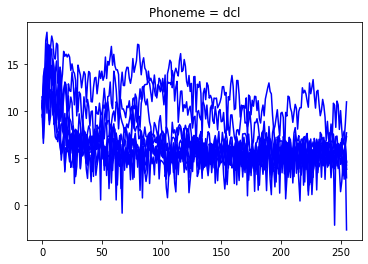

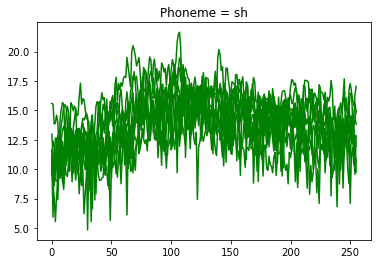

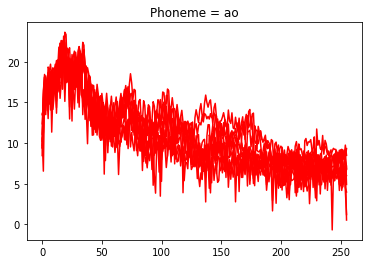

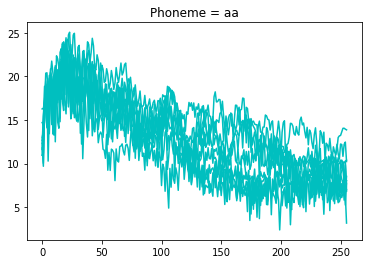

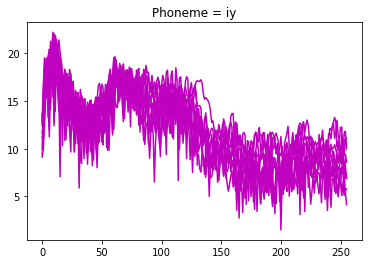

In [4]:
phoneme = set(y)
example_size = 10
colours = ['b','g','r','c','m']

for ph,col in zip(phoneme,colours):
    ph_example = X[y == ph][:example_size]
    plt.plot(ph_example.T,c=col)
    plt.title('Phoneme = {}'.format(ph))
    plt.show()

### Using natural cubic splines to modify the data

Here we have a couple of function implementing the Quadratic Discriminant analysis and computing the error

In [5]:
# Generate natural cubic spline basis
def natural_cubic_spline_mapping(X,ks):
    
    X = X.reshape((X.size,1))
    H = np.hstack((np.ones(X.shape),X))
    
    K1 = ks.pop()
    K2 = ks.pop()
    
    dK=(np.maximum(np.zeros(X.shape),(X-K2)**3)-np.maximum(np.zeros(X.shape),(X-K1)**3))/(K1-K2)
    
    for k in ks:
        dk=(np.maximum(np.zeros(X.shape),(X-k)**3)-np.maximum(np.zeros(X.shape),(X-K1)**3))/(K1-k)
        H = np.hstack((H,dk-dK))
    
    return H

# Filter signal X using natural spline with k=num_knots knots
def filtering(X,frequencies,num_freq,num_knots):
    
    spacing = num_freq//(num_knots+1)
    knots = [spacing*(i+1) for i in range(num_knots)]
    
    H = natural_cubic_spline_mapping(frequencies,knots)
    H = H/nla.norm(H,axis=0)
    
    return X @ H

def y_phoneme_to_class(y):
    
    N = y.size
    y_class = np.zeros(N)

    for i,ph in enumerate(phoneme):
        bool_ph = y == ph
        y_class[bool_ph] = i
                
    return y_class

def QDA(X_train,y_train,phoneme):

    N,p = X_train.shape

    discrimination = {}

    for n,ph in enumerate(phoneme):
        discrimination[ph] = {}
        relevant_data = y_train == n

        Nph = sum(relevant_data)
        X_ph = X_train[relevant_data]
        mu_ph = np.sum(X_ph,axis=0)/Nph
        sig_ph = (X_ph - mu_ph).T @ (X_ph - mu_ph)/(Nph-1)

        discrimination[ph]['prior_prob'] = Nph/N
        discrimination[ph]['moment'] = mu_ph
        discrimination[ph]['covariance'] = sig_ph

    return discrimination

def partitioning(batch_size,n,X,y):
    
    X_train = np.concatenate((X[:n*batch_size],X[(n+1)*batch_size:]))
    y_train = np.concatenate((y[:n*batch_size],y[(n+1)*batch_size:]))
    X_val = X[n*batch_size:(n+1)*batch_size]
    y_val = y[n*batch_size:(n+1)*batch_size]
    
    return (X_train,y_train,X_val,y_val)

def discriminant_function(x,mu,sig,prob):
    return - np.log(nla.det(sig))/2 - np.diag((x - mu) @ nla.pinv(sig) @ (x - mu).T) + np.log(prob)

def predict(X,discrimination,phoneme):
    
    discriminant_arr = []
    
    for ph in phoneme:
        prob = discrimination[ph]['prior_prob']
        mu = discrimination[ph]['moment']
        sigma = discrimination[ph]['covariance']

        discriminant_arr.append(discriminant_function(X,mu,sigma,prob))
    
    return np.argmax(discriminant_arr,axis=0)

def error(X,y,discrimination,phoneme):
    
    N = y.size
    y_predicted = predict(X,discrimination,phoneme)
    return np.mean(y_predicted != y)

Here we perfor the actual discrimination for different knots

In [6]:
# 5 different choices of knots
number_knots = [5,10,15,20,25,30,35,40,45]
lnk = len(number_knots)

K = 10

N, nf = X.shape
frequencies = np.arange(1,nf+1)

y_class = y_phoneme_to_class(y)

train_err = []
val_err = []
val_std_err = []

for nk in number_knots:
    # We filter the inputs according to the number of knots we choose
    X_filtered = filtering(X,frequencies,nf,nk)
    
    # 10-fold cross validation to choose best choice of knots
    train_error = []
    val_error = []
    
    for n in range(K):
        batch_size = N//K
        X_train,y_train, X_val, y_val = partitioning(batch_size,n,X_filtered,y_class)
        
        # Compute the apriori_probability, momenta and variance for the different classes
        discrimination = QDA(X_train,y_train,phoneme)
        
        # Compute the error on trianing and validation
        misc_err_train = error(X_train,y_train,discrimination,phoneme)
        train_error.append(misc_err_train)
        
        misc_err_val = error(X_val,y_val,discrimination,phoneme)
        val_error.append(misc_err_val)
        
    train_err.append(np.mean(train_error))
    val_err.append(np.mean(val_error))
    val_std_err.append(np.std(val_error)/np.sqrt(K))

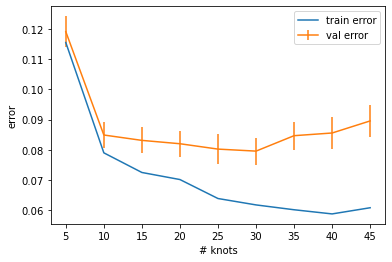

In [7]:
plt.plot(number_knots,train_err,label='train error')
plt.errorbar(number_knots,val_err,yerr=val_std_err,label='val error')
plt.ylabel('error')
plt.xlabel('# knots')
plt.legend()
plt.show()

Using one-standard-error rule, we would go for a filtering using k=10 knots.